In [7]:
import pandas as pd
import csv
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import re

from sklearn.metrics import f1_score


# define plot style
plt.style.use('seaborn')

# font sizes
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# GAB CORPUS

In [9]:
# load txt files, each with a  from different models
perplexity = {}
directory = '../../0_results/mlm'
for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        with open(os.path.join(directory, filename), 'r') as file:
            perplexity[os.path.splitext(filename)[0]] = file.read().replace('\n', '')
        continue
    else:
        continue

In [169]:
# PSEUDO-PERPLEXITY FOR EACH MODEL (ROW) ON EACH TEST SET (COLUMN)

models = pd.Series(perplexity.keys())[~pd.Series(perplexity.keys()).str.contains('rand')]
models = pd.unique(sorted(models.str[:10]))

score_series = {}
for model in models:
    score_series[model] = []
    for key in sorted(perplexity):
        if model in key and 'rand' not in key:
            score_series[model].append(round(float(perplexity[key]),2))
            
out_df = pd.DataFrame.from_dict(score_series).reset_index().rename(columns={'index':'model'})
out_df.columns = out_df.columns.str.replace('bert-', '')
out_df['model'] = out_df['model'].apply(lambda x: f'0{x+1}_10k' if x+1!=10 else f'{x+1}_10k')
out_df.set_index('model', inplace=True)
out_df = out_df.T

cm = sns.color_palette('Greens_r', as_cmap=True)
out_df.style.background_gradient(cmap=cm, axis = 0 ).format('{0:,.2f}')

model,01_10k,02_10k,03_10k,04_10k,05_10k,06_10k,07_10k,08_10k,09_10k,10_10k
01_1m,10.13,10.87,11.00,11.27,11.33,12.08,11.80,12.45,12.45,12.46
02_1m,10.73,10.02,10.57,11.09,11.14,12.03,11.74,12.25,12.41,12.38
03_1m,11.01,10.65,9.77,10.73,10.96,11.83,11.55,12.06,12.27,12.16
04_1m,11.09,10.91,10.42,9.85,10.57,11.55,11.45,11.94,12.08,12.06
05_1m,11.16,10.97,10.61,10.61,9.86,11.29,11.21,11.82,11.96,11.93
06_1m,11.31,11.27,10.92,10.99,10.57,10.33,10.87,11.72,11.89,11.82
07_1m,11.44,11.34,11.10,11.24,10.93,11.26,10.18,11.45,11.62,11.61
08_1m,11.61,11.48,11.20,11.38,11.09,11.63,11.00,10.31,10.84,11.17
09_1m,11.78,11.57,11.28,11.56,11.37,11.91,11.26,11.12,9.64,10.62
10_1m,11.76,11.68,11.44,11.63,11.41,11.99,11.41,11.46,10.60,9.81


In [261]:
# RELATIVE PSEUDO-PERPLEXITY FOR EACH MODEL (ROW) ON EACH TEST SET (COLUMN)

COMPARISON = 'bert-rand-1m'

score_series[COMPARISON] = []
for key in sorted(pd.Series(perplexity.keys())[pd.Series(perplexity.keys()).str.contains(COMPARISON)])[:10]:
    score_series[COMPARISON].append(perplexity[key])
    
rel_out_df = out_df.div(pd.Series(score_series[COMPARISON], index=out_df.columns).astype(float), axis=1).sub(1)
rel_out_df.style.background_gradient(cmap=cm, axis = 1).format('{0:,.2%}')

model,01_10k,02_10k,03_10k,04_10k,05_10k,06_10k,07_10k,08_10k,09_10k,10_10k
01_1m,-5.77%,2.48%,5.27%,6.22%,8.89%,15.90%,9.23%,17.94%,15.97%,17.60%
02_1m,-0.19%,-5.53%,1.16%,4.53%,7.06%,15.42%,8.67%,16.04%,15.60%,16.85%
03_1m,2.42%,0.41%,-6.50%,1.13%,5.33%,13.50%,6.91%,14.24%,14.30%,14.77%
04_1m,3.16%,2.86%,-0.28%,-7.16%,1.58%,10.81%,5.99%,13.10%,12.53%,13.83%
05_1m,3.81%,3.42%,1.54%,0.00%,-5.24%,8.32%,3.77%,11.97%,11.41%,12.60%
06_1m,5.21%,6.25%,4.51%,3.58%,1.58%,-0.89%,0.62%,11.02%,10.76%,11.56%
07_1m,6.42%,6.91%,6.23%,5.94%,5.04%,8.03%,-5.77%,8.46%,8.24%,9.58%
08_1m,8.00%,8.23%,7.19%,7.26%,6.58%,11.58%,1.82%,-2.34%,0.98%,5.43%
09_1m,9.58%,9.08%,7.95%,8.96%,9.27%,14.27%,4.23%,5.34%,-10.20%,0.24%
10_1m,9.39%,10.12%,9.48%,9.62%,9.65%,15.03%,5.62%,8.56%,-1.26%,-7.41%


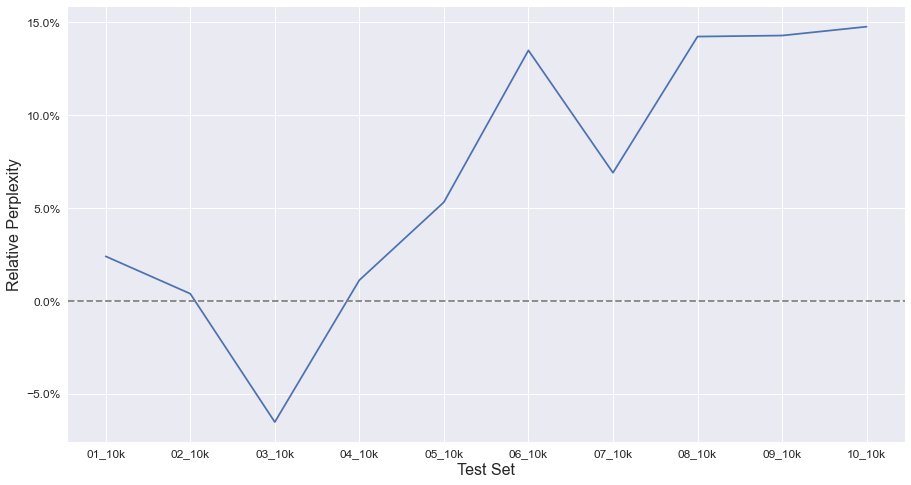

In [264]:
PLOT_MODEL = 3

fig, ax = plt.subplots(1,1, figsize=(15,8))

ax.plot(rel_out_df.columns, rel_out_df.iloc[PLOT_MODEL-1])
plt.axhline(y=0, color='gray', linestyle='--')
plt.xlabel(f'Test Set')
plt.ylabel(f'Relative Perplexity')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()

In [255]:
search_keys = sorted(pd.Series(perplexity.keys())[pd.Series(perplexity.keys()).str.contains('rand_10k')])

out_dict = { key: float(perplexity[key]) for key in search_keys }
pd.DataFrame.from_dict(out_dict, orient='index').style.background_gradient(cmap=cm, axis = 0 ).format('{0:,.2f}')

,0
bert-01_1m-rand_10k,11.99
bert-02_1m-rand_10k,11.77
bert-03_1m-rand_10k,11.74
bert-04_1m-rand_10k,11.64
bert-05_1m-rand_10k,11.49
bert-06_1m-rand_10k,11.51
bert-07_1m-rand_10k,11.50
bert-08_1m-rand_10k,11.61
bert-09_1m-rand_10k,11.61
bert-10_1m-rand_10k,11.65


In [257]:
search_keys = sorted(pd.Series(perplexity.keys())[pd.Series(perplexity.keys()).str.contains('bert-rand-1m')])[:10]

out_dict = { key: float(perplexity[key]) for key in search_keys }
pd.DataFrame.from_dict(out_dict, orient='index').style.background_gradient(cmap=cm, axis = 0 ).format('{0:,.2f}')

,0
bert-rand-1m-01_10k,10.75
bert-rand-1m-02_10k,10.61
bert-rand-1m-03_10k,10.45
bert-rand-1m-04_10k,10.61
bert-rand-1m-05_10k,10.41
bert-rand-1m-06_10k,10.42
bert-rand-1m-07_10k,10.80
bert-rand-1m-08_10k,10.56
bert-rand-1m-09_10k,10.74
bert-rand-1m-10_10k,10.59


# REDDIT CORPUS

In [42]:
# load txt files with perplexity values
perplexity = {}
directory = '../../0_results/reddit/mlm/month-models'
for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        with open(os.path.join(directory, filename), 'r') as file:
            perplexity[os.path.splitext(filename)[0]] = file.read().replace('\n', '')
        continue
    else:
        continue

In [46]:
# PSEUDO-PERPLEXITY FOR EACH MODEL (ROW) ON EACH TEST SET (COLUMN)

score_series = {}
for model in pd.unique(sorted(pd.Series(perplexity.keys()).apply(lambda x: re.search(r'(.*?)-test(.*?)', x).group(1)))):
    #if any("_"+year in model for year in YEAR_FILTER):
    score_series[model] = {}
    for key in sorted(perplexity):
        if model in key and "rand" not in key: #and any("_"+year in re.search(r'(.*?)k-(.*)', key).group(2) for year in YEAR_FILTER):
            score_series[model][re.search(r'(.*?)m-(.*)_10k', key).group(2)] = float(perplexity[key])

out_df = pd.DataFrame.from_dict(score_series).reset_index().rename(columns={'index':'model'})

out_df.set_index('model', inplace=True)

cm = sns.color_palette('Greens_r', as_cmap=True)

out_df.T.style.background_gradient(cmap=cm, axis = 0).format('{0:.2f}')

model,test_2017_03,test_2017_04,test_2017_05,test_2017_06,test_2017_07,test_2017_08,test_2017_09,test_2017_10,test_2017_11,test_2017_12,test_2018_01,test_2018_02,test_2018_03,test_2018_04,test_2018_05,test_2018_06,test_2018_07,test_2018_08,test_2018_09,test_2018_10,test_2018_11,test_2018_12,test_2019_01,test_2019_02,test_2019_03,test_2019_04,test_2019_05,test_2019_06,test_2019_07,test_2019_08,test_2019_09,test_2019_10,test_2019_11,test_2019_12,test_2020_01,test_2020_02
bert-2017_03_1m,7.11,7.48,7.26,7.38,7.56,7.34,7.66,7.75,7.60,7.57,7.70,7.76,8.02,7.80,7.61,7.72,7.60,7.61,7.92,7.87,7.69,7.97,7.87,8.03,7.79,7.87,7.83,7.86,7.92,8.03,7.87,8.05,7.97,7.95,8.25,8.20
bert-2017_04_1m,7.28,7.23,7.31,7.44,7.62,7.30,7.61,7.77,7.65,7.60,7.73,7.83,8.04,7.76,7.65,7.77,7.68,7.65,7.98,7.95,7.74,8.05,7.93,8.05,7.84,7.94,7.87,7.93,7.94,8.08,7.95,8.12,8.01,8.04,8.30,8.25
bert-2017_05_1m,7.30,7.47,7.12,7.35,7.61,7.30,7.66,7.74,7.63,7.57,7.72,7.80,8.02,7.79,7.63,7.77,7.62,7.63,7.93,7.95,7.69,7.99,7.92,8.00,7.79,7.90,7.81,7.89,7.90,8.03,7.96,8.07,7.98,7.94,8.25,8.23
bert-2017_06_1m,7.30,7.50,7.28,7.23,7.58,7.34,7.61,7.71,7.61,7.56,7.72,7.79,8.01,7.78,7.61,7.73,7.62,7.58,7.90,7.91,7.68,7.98,7.88,7.97,7.76,7.85,7.76,7.87,7.84,7.99,7.88,8.04,7.93,7.93,8.24,8.18
bert-2017_07_1m,7.28,7.48,7.29,7.35,7.39,7.29,7.60,7.71,7.54,7.50,7.66,7.74,8.00,7.72,7.53,7.68,7.60,7.59,7.88,7.84,7.60,7.94,7.83,7.94,7.73,7.81,7.74,7.82,7.79,7.93,7.85,7.98,7.89,7.86,8.16,8.12
bert-2017_08_1m,7.37,7.54,7.35,7.49,7.62,7.07,7.56,7.69,7.59,7.56,7.68,7.81,7.99,7.74,7.59,7.71,7.61,7.55,7.90,7.88,7.68,7.97,7.88,7.99,7.76,7.87,7.79,7.80,7.86,7.97,7.90,8.04,7.94,7.96,8.22,8.20
bert-2017_09_1m,7.36,7.55,7.39,7.50,7.64,7.25,7.36,7.64,7.57,7.55,7.67,7.78,7.97,7.75,7.56,7.68,7.61,7.58,7.87,7.86,7.67,7.96,7.83,7.93,7.77,7.83,7.74,7.80,7.84,7.93,7.86,7.98,7.88,7.92,8.18,8.15
bert-2017_10_1m,7.35,7.56,7.39,7.45,7.62,7.31,7.57,7.39,7.47,7.48,7.65,7.63,7.90,7.70,7.52,7.65,7.56,7.49,7.80,7.85,7.60,7.93,7.79,7.90,7.64,7.78,7.71,7.76,7.80,7.82,7.79,7.94,7.82,7.84,8.13,8.07
bert-2017_11_1m,7.36,7.57,7.35,7.44,7.64,7.35,7.63,7.58,7.27,7.44,7.60,7.65,7.91,7.65,7.53,7.62,7.53,7.50,7.78,7.82,7.58,7.90,7.76,7.91,7.69,7.78,7.69,7.79,7.77,7.82,7.74,7.92,7.81,7.84,8.10,8.07
bert-2017_12_1m,7.35,7.55,7.35,7.43,7.60,7.33,7.61,7.63,7.39,7.25,7.57,7.66,7.90,7.64,7.49,7.62,7.52,7.50,7.82,7.81,7.54,7.89,7.77,7.85,7.66,7.75,7.63,7.73,7.72,7.83,7.75,7.91,7.82,7.81,8.09,8.01


In [37]:
# load perplexities for total models:
directory = '../../0_results/reddit/mlm/total-models'
for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        with open(os.path.join(directory, filename), 'r') as file:
            perplexity[os.path.splitext(filename)[0]] = file.read().replace('\n', '')
        continue
    else:
        continue

In [39]:
search_keys = sorted(pd.Series(perplexity.keys())[pd.Series(perplexity.keys()).str.contains('rand_10k')])

out_dict = { key: float(perplexity[key]) for key in search_keys }
pd.DataFrame.from_dict(out_dict, orient='index').style.background_gradient(cmap=cm, axis = 0 ).format('{0:,.2f}')

,0
bert-rand_1m-test_rand_10k,7.71
bert-rand_2m-test_rand_10k,7.22
bert-rand_5m-test_rand_10k,6.63
